Name : Muhammad Afif Alvan

Role : Machine Learning Engineer

## 📘 Deskripsi Proyek

Notebook ini dibuat sebagai bagian dari *Technical Test: Stock Price Forecasting*, dengan tujuan membangun dan mengevaluasi model *machine learning* untuk memprediksi harga penutupan (*closing price*) harian saham Indonesia pada hari berikutnya.  

Proyek ini tidak hanya menekankan pada pengembangan model yang akurat, tetapi juga pada penerapan praktik **MLOps**, khususnya dalam hal pelacakan eksperimen dan manajemen model menggunakan **MLflow**.

---

## 🎯 Tujuan Proyek

1. Mengembangkan model *machine learning* untuk memprediksi harga penutupan saham Indonesia untuk hari berikutnya berdasarkan data historis.

2. Menerapkan praktik **MLOps** dengan mengintegrasikan **MLflow** atau **Comet** untuk:
   - Melacak eksperimen (parameter, metrik, *artifact*).
   - Menyimpan dan mengelola versi model.
   - Menjaga kualitas kode yang baik, modular, dan mudah direproduksi atau dikembangkan lebih lanjut.

3. Memberikan hasil dan visualisasi yang informatif untuk membantu interpretasi model dan performanya.


# Install Depedensi

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [57]:
pip install mplfinance


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [58]:
pip install mlflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [60]:
pip install LightGBM

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import Libraires

In [2]:
# Import Libraries 
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

# Modeling Evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import mlflow
import mlflow.sklearn

# Data Loading

In [ ]:
# Final version without 'Price' check
def get_clean_stock_data(ticker, start="2025-08-02", end="2025-09-31"):
    data = yf.download(ticker, start=start, end=end)

    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    data.reset_index(inplace=True)

    columns_order = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    data = data[[col for col in columns_order if col in data.columns]]

    return data


data = get_clean_stock_data("BBCA.JK")
data.to_csv('actual.csv')


C:\Users\afifa\AppData\Local\Temp\ipykernel_19852\2873633414.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed


In [6]:
print(data.columns)
data.info()

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object', name='Price')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3 non-null      datetime64[ns]
 1   Open    3 non-null      float64       
 2   High    3 non-null      float64       
 3   Low     3 non-null      float64       
 4   Close   3 non-null      float64       
 5   Volume  3 non-null      int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 276.0 bytes


# Data Cleaning

In [64]:
# Function Data Cleaning
def clean_stock_data(df):
    """
    Membersihkan data saham:
    - Konversi tipe tanggal
    - Urutkan berdasarkan tanggal
    - Hapus duplikat
    - Cek dan tangani missing values
    - Cek nilai negatif atau nol
    - Cek dan laporkan anomali harga
    - Pastikan semua kolom numerik bertipe numerik
    - Cek tanggal bisnis yang hilang
    
    Return:
        df_bersih: DataFrame yang telah dibersihkan
    """
    df = df.copy()

    # Konversi tanggal dan urutkan
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    # Hapus duplikat
    df = df.drop_duplicates()

    # Ubah kolom numerik ke float
    cols_to_numeric = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in cols_to_numeric:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Tangani missing values (NaN)
    if df.isnull().sum().sum() > 0:
        print("Missing values found, applying forward fill and backward fill...")
        df = df.fillna(method='ffill').fillna(method='bfill')

    # Cek nilai negatif atau nol
    if (df[cols_to_numeric] <= 0).any().any():
        print("Warning: Terdapat nilai <= 0 di kolom harga/volume.")
        print((df[cols_to_numeric] <= 0).sum())

    # Cek anomali harga (Close tidak boleh < Low atau > High, Low tidak boleh > High)
    epsilon = 1e-6
    anomalies = df[
        (df['Close'] - df['High'] > epsilon) |
        (df['Low'] - df['Close'] > epsilon) |
        (df['Low'] - df['High'] > epsilon)
    ]
    if not anomalies.empty:
        print(f"Ada {len(anomalies)} baris dengan anomali harga:")
        print(anomalies)

    # Cek apakah ada tanggal bisnis yang hilang (tidak dihapus, hanya info)
    business_days = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='B')
    missing_dates = business_days.difference(df['Date'])
    if len(missing_dates) > 0:
        print(f"Terdapat {len(missing_dates)} tanggal bisnis yang hilang (mungkin hari libur):")
        print(missing_dates.strftime('%Y-%m-%d').tolist())

    return df
data_clean = clean_stock_data(data)


Price
Open      0
High      0
Low       0
Close     0
Volume    2
dtype: int64
Terdapat 113 tanggal bisnis yang hilang (mungkin hari libur):
['2020-03-25', '2020-04-10', '2020-05-01', '2020-05-07', '2020-05-21', '2020-05-22', '2020-05-25', '2020-06-01', '2020-07-31', '2020-08-17', '2020-08-20', '2020-08-21', '2020-10-28', '2020-10-29', '2020-10-30', '2020-12-09', '2020-12-24', '2020-12-25', '2020-12-31', '2021-01-01', '2021-02-12', '2021-03-11', '2021-04-02', '2021-05-12', '2021-05-13', '2021-05-14', '2021-05-26', '2021-06-01', '2021-07-20', '2021-08-11', '2021-08-17', '2021-10-20', '2021-12-31', '2022-02-01', '2022-02-28', '2022-03-03', '2022-04-15', '2022-04-29', '2022-05-02', '2022-05-03', '2022-05-04', '2022-05-05', '2022-05-06', '2022-05-16', '2022-05-26', '2022-06-01', '2022-08-17', '2023-01-23', '2023-03-22', '2023-03-23', '2023-04-07', '2023-04-19', '2023-04-20', '2023-04-21', '2023-04-24', '2023-04-25', '2023-05-01', '2023-05-18', '2023-06-01', '2023-06-02', '2023-06-28', '202

In [65]:
# Tampilkan baris dengan volume nol atau negatif
invalid_volume_rows = data_clean[data_clean['Volume'] <= 0]
print(invalid_volume_rows)

Price       Date        Open        High         Low       Close  Volume
51    2020-03-13  4837.72168  4837.72168  4837.72168  4837.72168       0
52    2020-03-16  4837.72168  4837.72168  4837.72168  4837.72168       0


In [ ]:
# Menghilangkan baris
invalid_volume_rows = data_clean[data_clean['Volume'] <= 0]
print(invalid_volume_rows)
data = data_clean[data_clean['Volume'] > 0].reset_index(drop=True)
print((data_clean['Volume'] <= 0).sum())

2


## 🧹 Data Cleaning Summary

### 1. Nilai Volume ≤ 0
- Ditemukan **2 baris** dengan `Volume` ≤ 0 (tidak wajar secara finansial).
- ✅ **Tindakan:** Baris dihapus.
- Kolom harga (`Open`, `High`, `Low`, `Close`) bersih dari nilai nol/negatif.

📌 Volume nol biasanya karena:
- Saham disuspensi atau tidak aktif.
- Likuiditas rendah.
- Kesalahan data.

### 2. Tanggal Bisnis Hilang
- Ditemukan **113 hari kerja** yang hilang.
- Umumnya disebabkan oleh libur nasional, akhir pekan panjang, atau penutupan bursa.

✅ **Tindakan:** **Tidak diimputasi**, karena ini wajar pada data pasar saham.

---

### ✅ Kesimpulan
Dataset telah dibersihkan dan siap digunakan untuk analisis atau pelatihan model.


# Data Visualization

## 📊 Data Visualization

Untuk memahami data harga saham secara visual, digunakan beberapa grafik berikut:

1. **Line Chart Harga Penutupan:** Menunjukkan tren jangka panjang saham.
2. **Volume Perdagangan:** Mengilustrasikan aktivitas beli/jual pasar setiap harinya.
3. **Candlestick Chart:** Visualisasi OHLC (Open, High, Low, Close) untuk menggambarkan pergerakan harga secara lebih detail dalam periode tertentu.


In [67]:
# Function Visualization

## 1. Line Chart Harga Penutupan
def plot_close_price(df):
    plt.figure(figsize=(14, 6))
    plt.plot(df['Date'], df['Close'], label='Close Price')
    plt.title('Harga Penutupan Saham dari Waktu ke Waktu')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Penutupan')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 2. Volume Perdagangan
def plot_volume(df):
    plt.figure(figsize=(14, 4))
    plt.bar(df['Date'], df['Volume'], width=1.0)
    plt.title('Volume Perdagangan Harian')
    plt.xlabel('Tanggal')
    plt.ylabel('Volume')
    plt.tight_layout()
    plt.show()

## 3. Candlestick Chart
def plot_candlestick(df, days=60):
    try:
        ohlc = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].copy()
        ohlc.set_index('Date', inplace=True)
        mpf.plot(
            ohlc.tail(days),
            type='candle',
            volume=True,
            style='yahoo',
            title=f'Candlestick Chart ({days} Hari Terakhir)'
        )
    except Exception as e:
        print(f"❗ Gagal menampilkan candlestick chart: {e}")


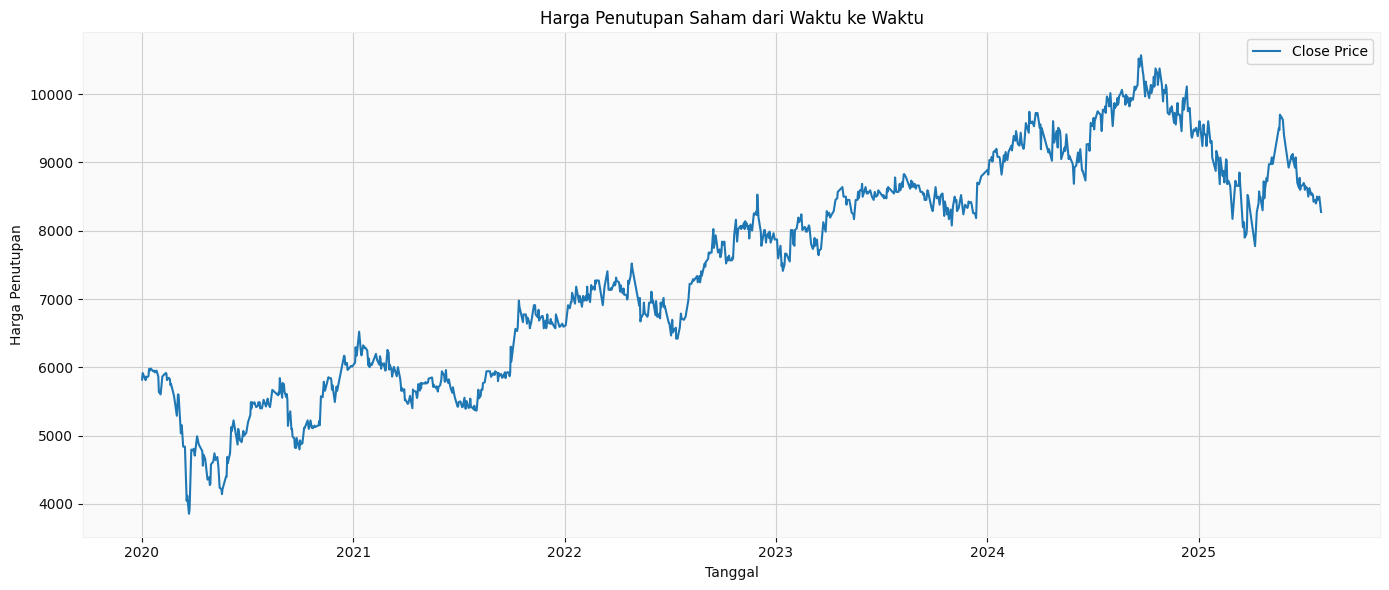

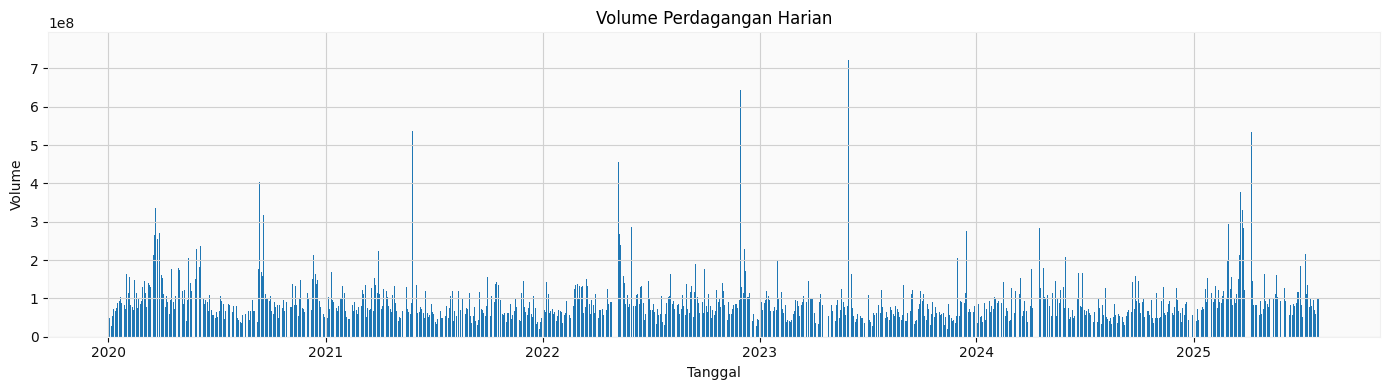

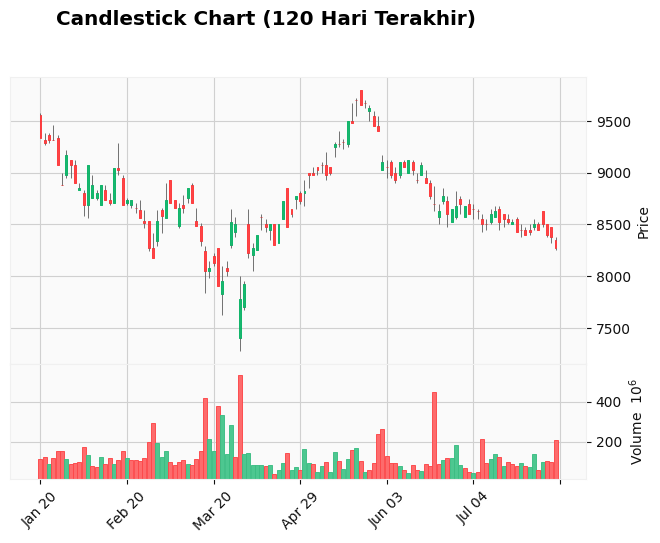

In [ ]:

plot_close_price(data_clean)
plot_volume(data_clean)
# Atur days sesuai dengan kebutuhan beberapa hari sebelumnya.
plot_candlestick(data_clean, days=120)


# Data Preprocessing

## Feature Engineering

In [69]:
mkjhkl

NameError: name 'mkjhkl' is not defined

In [8]:

def create_features(df, lags=[1, 2, 3], rolling_windows=[5, 10]):
    """
    Membuat fitur lag dan rolling untuk modeling time series regression.
    Target: Close(t+1)
    """
    df = df.copy()

    # Pastikan data terurut
    df = df.sort_values("Date").reset_index(drop=True)

    # LAG features
    for lag in lags:
        df[f"lag_close_{lag}"] = df["Close"].shift(lag)

    # Rolling mean & std
    for window in rolling_windows:
        df[f"roll_mean_{window}"] = df["Close"].shift(1).rolling(window=window).mean()
        df[f"roll_std_{window}"] = df["Close"].shift(1).rolling(window=window).std()

    # Target: Close price esok hari
    df["target"] = df["Close"].shift(-1)

    # Drop baris dengan NaN (dari shifting/rolling)
    df = df.dropna().reset_index(drop=True)
    
    return df


In [ ]:
data_fe = create_features(data)
data_fe.head()

## Train-Test Split

In [11]:
# Func train test split
def time_series_train_test_split(df, test_size=0.2):
    df = df.copy()
    split_index = int(len(df) * (1 - test_size))
    
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]
    
    return train_df, test_df

# running
train_df, test_df = time_series_train_test_split(data_fe, test_size=0.2)
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (1065, 14)
Test shape: (267, 14)


In [ ]:

# Splitting kolom Target
def split_X_y(df, target_col="target", drop_cols=["Date"]):
    feature_cols = [col for col in df.columns if col not in drop_cols + [target_col]]
    X = df[feature_cols]
    y = df[target_col]
    return X, y
X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

OKE KITA PUNYA data_fe yang sudah di split x_train dll nya

# Baseline Model


## Naive Forecast

In [ ]:
# Function Baseline
def baseline_naive_forecast(test_df, lag_column="lag_close_1", target_column="target"):
    y_true = test_df[target_column].values
    y_pred = test_df[lag_column].values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"[Baseline] RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.4f}")
    
    return {
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "y_true": y_true,
        "y_pred": y_pred
    }
baseline_result = baseline_naive_forecast(test_df)
baseline_result

### Baseline Vs Actual

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(test_df['Date'], baseline_result["y_true"], label='Actual Close Price', linewidth=2)
plt.plot(test_df['Date'], baseline_result["y_pred"], label='Naive Forecast (Lag 1)', linestyle='--')
plt.title("Baseline Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
435fdsf

# Linear Regression with lagged Futures

In [17]:
def train_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        "y_pred": y_pred,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }


In [ ]:

# 1. Training
lr_model = train_linear_regression(X_train, y_train)

# 2. Evaluasi
lr_result = evaluate_model(lr_model, X_test, y_test)

# 3. Lihat hasilnya
print(f"RMSE: {lr_result['rmse']:.2f}")
print(f"MAE : {lr_result['mae']:.2f}")
print(f"R2  : {lr_result['r2']:.4f}")

In [ ]:
def plot_baseline_predictions(dates, y_true, y_pred, title="Baseline Forecast vs Actual"):
    plt.figure(figsize=(14, 6))
    plt.plot(dates, y_true, label='Actual Close Price', linewidth=2)
    plt.plot(dates, y_pred, label='Naive Forecast (Lag 1)', linestyle='--')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_baseline_predictions(
    dates=test_df['Date'],
    y_true=y_test,
    y_pred=lr_result['y_pred'],
    title="Linear Regression Forecast vs Actual"
)

# MLflow

In [ ]:
def log_to_mlflow(model, X_test, y_test, y_pred, run_name="LinearRegression"):
    """
    Log model, metrics, and a plot to MLflow.
    """
    with mlflow.start_run(run_name=run_name):
        # Log parameters (you can expand if you use more)
        mlflow.log_param("model_type", "LinearRegression")

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Log metrics
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("R2", r2)

        # Log model
        mlflow.sklearn.log_model(model, artifact_path="model")

        # Save & log plot
        plt.figure(figsize=(10,5))
        plt.plot(y_test.values, label="Actual")
        plt.plot(y_pred, label="Predicted")
        plt.title("Linear Regression Forecast vs Actual")
        plt.xlabel("Time")
        plt.ylabel("Close Price")
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.savefig("lr_forecast_plot.png")
        mlflow.log_artifact("lr_forecast_plot.png")
        plt.close()

        print(f"Logged to MLflow: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.4f}")


In [ ]:
log_to_mlflow(lr_model, X_test, y_test, lr_result['y_pred'], run_name="LinearRegression_v1")


# XGBoost

In [9]:
data_fe = create_features(data)
data_fe.head()

Price,Date,Open,High,Low,Close,Volume,lag_close_1,lag_close_2,lag_close_3,roll_mean_5,roll_std_5,roll_mean_10,roll_std_10,target
0,2020-01-16,5920.987387,5994.945348,5912.286450,5960.141602,88931500,5947.090332,5977.543945,5868.782227,5901.845801,56.606165,5878.353467,52.957319,5981.894043
1,2020-01-17,5951.440764,5994.945448,5916.637017,5981.894043,38249500,5960.141602,5947.090332,5977.543945,5920.987598,56.972897,5892.274902,54.460754,5947.090332
2,2020-01-20,6047.151106,6068.903448,5942.739864,5947.090332,93554500,5981.894043,5960.141602,5947.090332,5947.090430,45.938045,5898.800586,61.197301,5942.740723
3,2020-01-21,5990.595882,5999.296820,5938.390254,5942.740723,103984500,5947.090332,5981.894043,5960.141602,5962.752051,16.451515,5907.501416,61.266009,5951.440918
4,2020-01-22,5964.492323,5999.296072,5947.090449,5951.440918,94311500,5942.740723,5947.090332,5981.894043,5955.791406,15.984442,5915.332227,60.143704,5951.440918


In [14]:
train_df, test_df = time_series_train_test_split(data_fe, test_size=0.2)
X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [15]:
model = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)

In [ ]:

xgb_evaluation = evaluate_model(model, X_test, y_test)

print("[XGBoost Evaluation]")
print(f"RMSE: {xgb_evaluation['rmse']:.2f}")
print(f"MAE : {xgb_evaluation['mae']:.2f}")
print(f"R²  : {xgb_evaluation['r2']:.4f}")

[XGBoost Evaluation]
RMSE: 307.64
MAE : 232.01
R²  : 0.7731


In [ ]:

plot_baseline_predictions(
    dates=test_df['Date'],
    y_true=y_test,
    y_pred=xgb_evaluation['y_pred'],
    title="Linear Regression Forecast vs Actual"
)

In [21]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from xgboost import XGBRegressor

# 1. Parameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# 2. TimeSeriesSplit untuk validasi yang sesuai urutan waktu
tscv = TimeSeriesSplit(n_splits=5)

# 3. Inisialisasi model dan GridSearchCV
xgb = XGBRegressor(random_state=42, verbosity=0)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# 4. Fit ke data training
grid_search.fit(X_train, y_train)

# 5. Lihat hasil terbaik
print("Best parameters:", grid_search.best_params_)
print("Best RMSE:", -grid_search.best_score_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best RMSE: 367.6769713039274


In [20]:
# Ambil model terbaik dari GridSearch
best_xgb = grid_search.best_estimator_

# Evaluasi di test set
xgb_tuned_evaluation = evaluate_model(best_xgb, X_test, y_test)

# Tampilkan hasil evaluasi
print("[XGBoost Tuned Evaluation]")
print(f"RMSE: {xgb_tuned_evaluation['rmse']:.2f}")
print(f"MAE : {xgb_tuned_evaluation['mae']:.2f}")
print(f"R²  : {xgb_tuned_evaluation['r2']:.4f}")

[XGBoost Tuned Evaluation]
RMSE: 323.88
MAE : 244.85
R²  : 0.7485


In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Train model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Log results
    print(f"[{model_name} Evaluation]")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"R²  : {r2:.4f}")

    return {
        "model": model,
        "y_pred": y_pred,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }


In [23]:
# Linear Regression
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_results = train_and_evaluate_model(lr_model, X_train, y_train, X_test, y_test, model_name="Linear Regression")

# XGBoost
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
xgb_results = train_and_evaluate_model(xgb_model, X_train, y_train, X_test, y_test, model_name="XGBoost")

# LightGBM
from lightgbm import LGBMRegressor
lgbm_model = LGBMRegressor(n_estimators=100, max_depth=3, random_state=42)
lgbm_results = train_and_evaluate_model(lgbm_model, X_train, y_train, X_test, y_test, model_name="LightGBM")


[Linear Regression Evaluation]
RMSE: 146.32
MAE : 109.92
R²  : 0.9487
[XGBoost Evaluation]
RMSE: 307.64
MAE : 232.01
R²  : 0.7731
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 1065, number of used features: 12
[LightGBM] [Info] Start training from score 6988.792734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

# ARIMA

In [24]:
import pandas as pd

# Pastikan kolom Date jadi index datetime
df_arima = data.copy()
df_arima['Date'] = pd.to_datetime(df_arima['Date'])
df_arima.set_index('Date', inplace=True)

# Ambil hanya kolom Close
ts_data = df_arima['Close']


In [25]:
# Split manual (sama proporsi seperti sebelumnya)
split_index = int(len(ts_data) * 0.8)
train_arima = ts_data[:split_index]
test_arima = ts_data[split_index:]


In [26]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [73]:
pip install -U numpy Cython

  Using cached cython-3.1.2-cp313-cp313-win_amd64.whl.metadata (6.0 kB)
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   ---- ----------------------------------- 1.6/12.8 MB 9.9 MB/s eta 0:00:02
   ----------- ---------------------------- 3.7/12.8 MB 10.9 MB/s eta 0:00:01
   ------------------ --------------------- 5.8/12.8 MB 10.3 MB/s eta 0:00:01
   ------------------------ --------------- 7.9/12.8 MB 9.9 MB/s eta 0:00:01
   ------------------------------ --------- 9.7/12.8 MB 9.8 MB/s eta 0:00:01
   ------------------------------------ --- 11.5/12.8 MB 9.7 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 9.2 MB/s  0:00:01
Using cached cython-3.1.2-cp313-cp313-win_amd64.whl (2.7 MB)

  Attempting uninstall: numpy

    Found existing installation: numpy 2.2.5

   ---------------------------------------- 0/2 [numpy]
    Uninstalling numpy-2.2.5:
   ---------------------------------------- 0/2 [numpy]
   ----------------------------------

  You can safely remove it manually.
  You can safely remove it manually.


In [74]:
pip install pmdarima


  Using cached pmdarima-2.0.4.tar.gz (630 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build pmdarima
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for pmdarima (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [43 lines of output]
      Partial import of pmdarima during the build process.
      
      Requirements: ['joblib>=0.11\nCython>=0.29,!=0.29.18,!=0.29.31\nnumpy>=1.21.2\npandas>=0.19\nscikit-learn>=0.22\nscipy>=1.3.2\nstatsmodels>=0.13.2\nurllib3\nsetuptools>=38.6.0,!=50.0.0\npackaging>=17.1  # Bundled with setuptools, but want to be explicit\n']
      Adding extra setuptools args
      Setting up with setuptools
      Traceback (most recent call last):
        File "c:\Users\afifa\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 389, in <module>
          main()
          ~~~~^^
        File "c:\Users\afifa\AppData\Local\Programs\Python\Python313\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 373, in main
          json_out["return_val"] = hook

In [ ]:
from pmdarima import auto_arima

# Tentukan model ARIMA optimal (auto search p,d,q)
model_auto = auto_arima(train_arima, seasonal=False, stepwise=True, suppress_warnings=True, trace=True)
model_auto.summary()


ModuleNotFoundError: No module named 'pmdarima'

In [27]:
# Forecast sebanyak jumlah data test
n_test = len(test_arima)
forecast = model_auto.predict(n_periods=n_test)

# Index sama dengan test
forecast = pd.Series(forecast, index=test_arima.index)


NameError: name 'model_auto' is not defined

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(test_arima, forecast))
mae = mean_absolute_error(test_arima, forecast)
r2 = r2_score(test_arima, forecast)

print("[ARIMA Evaluation]")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")


NameError: name 'forecast' is not defined

In [ ]:
pip install statsmodels

In [29]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def run_arima_forecast(data, order=(5,1,0), test_size=0.2):
    """
    Melatih model ARIMA pada data Close.
    
    Parameters:
        data (pd.DataFrame): DataFrame dengan kolom 'Date' dan 'Close'
        order (tuple): ARIMA(p,d,q) parameter
        test_size (float): Proporsi data yang digunakan sebagai test
    
    Returns:
        dict: hasil evaluasi dan prediksi
    """
    df = data.copy()
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)
    
    # Hanya gunakan kolom Close
    series = df['Close']
    
    # Train-test split
    split_index = int(len(series) * (1 - test_size))
    train, test = series[:split_index], series[split_index:]
    
    # Fit ARIMA
    model = ARIMA(train, order=order)
    model_fit = model.fit()
    
    # Forecast sepanjang test set
    forecast = model_fit.forecast(steps=len(test))
    
    # Evaluation
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mae = mean_absolute_error(test, forecast)
    r2 = r2_score(test, forecast)

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, forecast, label='Forecast')
    plt.title(f"ARIMA{order} Forecast")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "y_true": test.values,
        "y_pred": forecast.values,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }


c:\Users\afifa\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afifa\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afifa\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\afifa\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is ava

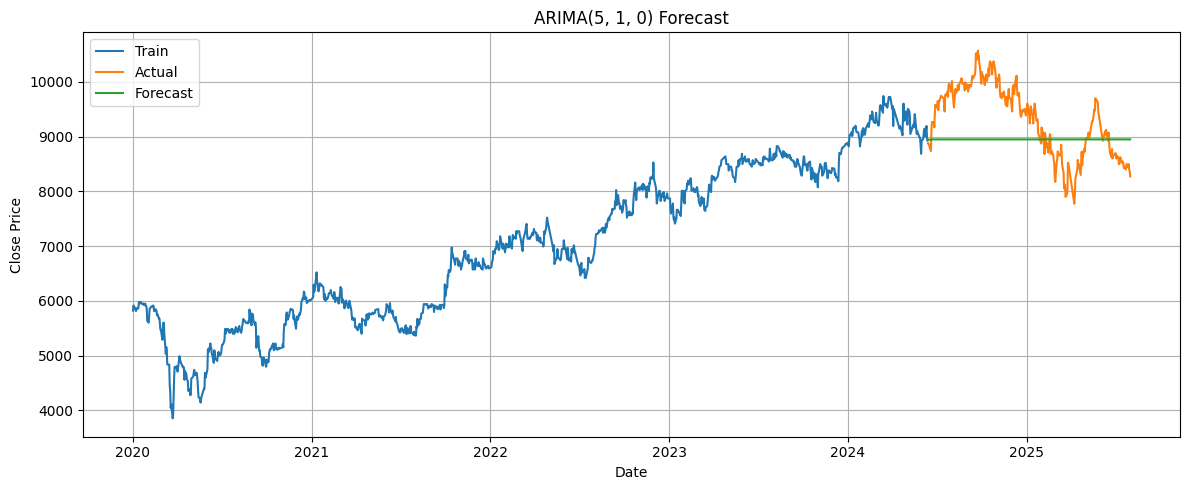

[ARIMA Evaluation]
RMSE: 751.68
MAE : 646.45
R²  : -0.3595


In [30]:
arima_result = run_arima_forecast(data, order=(5,1,0))
print(f"[ARIMA Evaluation]")
print(f"RMSE: {arima_result['rmse']:.2f}")
print(f"MAE : {arima_result['mae']:.2f}")
print(f"R²  : {arima_result['r2']:.4f}")


In [ ]:
pip install prophet

In [1]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

def run_prophet_forecast(data, test_size=0.2):
    """
    Melatih dan mengevaluasi model Prophet.
    
    Returns:
        dict: hasil evaluasi dan prediksi
    """
    df = data.copy()
    df = df.rename(columns={"Date": "ds", "Close": "y"})
    df = df[["ds", "y"]].sort_values("ds")
    
    split_index = int(len(df) * (1 - test_size))
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]
    
    model = Prophet()
    model.fit(train_df)
    
    future = model.make_future_dataframe(periods=len(test_df))
    forecast = model.predict(future)
    
    # Ambil hanya prediksi yang sesuai dengan test set
    y_pred = forecast.iloc[-len(test_df):]['yhat'].values
    y_true = test_df['y'].values
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(train_df['ds'], train_df['y'], label="Train")
    plt.plot(test_df['ds'], y_true, label="Actual")
    plt.plot(test_df['ds'], y_pred, label="Forecast")
    plt.title("Facebook Prophet Forecast")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return {
        "y_true": y_true,
        "y_pred": y_pred,
        "rmse": rmse,
        "mae": mae,
        "r2": r2
    }


c:\Users\afifa\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
prophet_result = run_prophet_forecast(data)

print("[Facebook Prophet Evaluation]")
print(f"RMSE: {prophet_result['rmse']:.2f}")
print(f"MAE : {prophet_result['mae']:.2f}")
print(f"R²  : {prophet_result['r2']:.4f}")


NameError: name 'data' is not defined

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def create_lstm_dataset(series, window_size=10):
    """
    Membuat dataset dalam bentuk X, y untuk LSTM.
    """
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)


In [ ]:
# Ambil hanya kolom Close
close_prices = data['Close'].values.reshape(-1, 1)

# Scaling
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(close_prices)

# Buat sequences
window_size = 10
X, y = create_lstm_dataset(scaled_close, window_size)

# Split manual
split_index = int(len(X) * 0.8)
X_train, y_train = X[:split_index], y[:split_index]
X_test, y_test = X[split_index:], y[split_index:]

# Reshape input agar sesuai LSTM: [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
pip install tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


model = build_lstm_model((window_size, 1))


c:\Users\afifa\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0426 - val_loss: 0.0193
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1423e-04 - val_loss: 0.0013
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.0179e-04 - val_loss: 0.0013
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8988e-04 - val_loss: 0.0012
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9908e-04 - val_loss: 0.0011
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8086e-04 - val_loss: 0.0011
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7513e-04 - val_loss: 0.0011
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8303e-04 - val_loss: 0.0013
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7171e-04 - val_loss: 0.0012
Epoch 12/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prediksi
y_pred_scaled = model.predict(X_test)

# Balik scaling
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluasi
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred))
mae = mean_absolute_error(y_test_inv, y_pred)
r2 = r2_score(y_test_inv, y_pred)

print("[LSTM Evaluation]")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[LSTM Evaluation]
RMSE: 207.28
MAE : 167.24
R²  : 0.8970


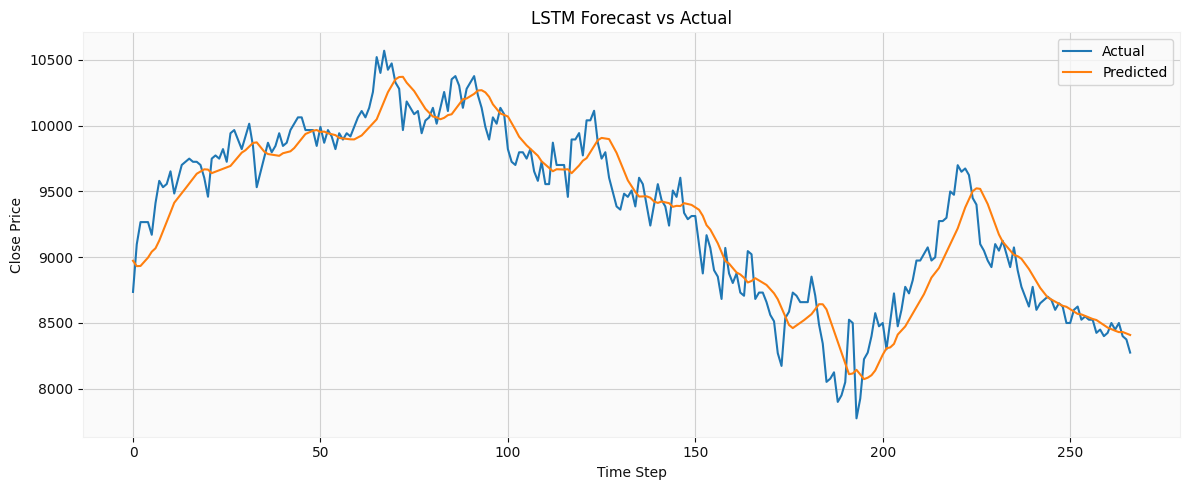

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Time Step")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Tunning

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Fungsi ubah ke supervised sequence
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)


In [ ]:
data

Price,Date,Open,High,Low,Close,Volume
0,2020-01-02,5825.277226,5899.235190,5812.225821,5820.926758,49445000
1,2020-01-03,5873.133006,5916.637695,5851.380662,5916.637695,47755500
2,2020-01-06,5847.030136,5873.132950,5820.927323,5860.081543,27300000
3,2020-01-07,5860.081660,5890.534943,5855.731191,5864.432129,45022500
4,2020-01-08,5803.525625,5868.782659,5803.525625,5812.226562,53692500
...,...,...,...,...,...,...
1336,2025-07-25,8500.000000,8525.000000,8450.000000,8450.000000,58682800
1337,2025-07-28,8625.000000,8625.000000,8475.000000,8500.000000,99484300
1338,2025-07-29,8500.000000,8500.000000,8375.000000,8400.000000,104240300
1339,2025-07-30,8475.000000,8475.000000,8325.000000,8375.000000,98098100


In [ ]:
# Func train test split
def time_series_train_test_split(df, test_size=0.2):
    df = df.copy()
    split_index = int(len(df) * (1 - test_size))
    
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]
    
    return train_df, test_df

# running
train_df, test_df = time_series_train_test_split(data, test_size=0.2)
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
# Splitting kolom Target
def split_X_y(df, target_col="Close", drop_cols=["Date"]):
    feature_cols = [col for col in df.columns if col not in drop_cols + [target_col]]
    X = df[feature_cols]
    y = df[target_col]
    return X, y
X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

Train shape: (1072, 6)
Test shape: (269, 6)


In [ ]:
# Normalisasi
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ubah ke sequence
window_size = 10  # bisa kamu tuning
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, window_size)


In [ ]:
def build_lstm_model(input_shape, n_neurons=64, dropout=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=n_neurons, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Inisialisasi model
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
model = build_lstm_model(input_shape=input_shape, n_neurons=64, dropout=0.3, learning_rate=0.001)

# Training
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)


Epoch 1/50


c:\Users\afifa\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 46926072.0000 - val_loss: 84748688.0000
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 46813772.0000 - val_loss: 84635704.0000
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 46755100.0000 - val_loss: 84581736.0000
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 46721336.0000 - val_loss: 84538376.0000
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 46690140.0000 - val_loss: 84497992.0000
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 46660388.0000 - val_loss: 84456392.0000
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 46630636.0000 - val_loss: 84417328.0000
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 46602192.0000 - val_loss: 84379096.0000
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 46573496.0000 - val_loss: 84341624.0000
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 46547528.0000 - val_loss: 84304496.0000
Epoch 11/50
30/30 ━━━━━━━━━━━

In [ ]:
# Prediksi
y_pred_seq = model.predict(X_test_seq)

# Evaluasi
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred_seq))
mae = mean_absolute_error(y_test_seq, y_pred_seq)
r2 = r2_score(y_test_seq, y_pred_seq)

print("[LSTM Tuned Evaluation]")
print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[LSTM Tuned Evaluation]
RMSE: 9257.99
MAE : 9234.84
R²  : -199.2679
